# 1. Define your experiment: Task model

## Bandit task

Parameters: 
* Number of option ($N$)
* Distribution of probability over these options ($\{p_{reward}(i)\}_{i\in N}$)
* Number of trials ($T$)

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import statsmodels.stats
import scipy.stats

EPS = np.finfo(np.float).eps

In [100]:
N = 2
p = np.array([0.5, 0.75])
T = 100

# 2. Define your decision-making models: Cognitive model

## Random

* Decision rule ($\tau$)

\begin{equation}
p_{choice}(i) \sim \text{Uniform}
\end{equation} 

* Updating rule

[None]

## Rescola-Wagner RL

* Decision rule ($\tau$)

\begin{equation}
p_{choice}(i) = \dfrac{\exp (v(i)/\tau)}{\sum_{j \in N} \exp (v(j)/\tau)} 
\end{equation}

* Updating rule ($\alpha$)

\begin{equation}
v^{t+1}(i) = v^t(i) + \alpha(s - v^t(i))
\end{equation}

In [101]:
class Random:
    
    """
    No-learning model
    """
    
    def __init__(self, n_option):
        self.n_option = n_option
        self.options = np.arange(n_option)
        
    def choose(self):
        p =  self.decision_rule()
        return np.random.choice(self.options, p=p)
        
    def learn(self, i, success):
        self.updating_rule(i, success)
    
    def decision_rule(self):
        return np.ones(self.options) / self.n_option
    
    def updating_rule(self, i, success):
        pass
        

In [102]:
class RL(Random):
    
    """
    Reinforcement learning model
    """
    
    def __init__(self, n_option, learning_rate, temp, initial_value=0.5):
        super().__init__(n_option)
        self.values = np.full(n_option, initial_value)
        self.learning_rate = learning_rate
        self.temp = temp
    
    def decision_rule(self):
        return np.exp(self.values/self.temp) / \
               np.sum(np.exp(self.values/self.temp))
        
    def updating_rule(self, i, success):
        self.values[i] += self.learning_rate * (success - self.values[i])

# 3. Simulate 

In [103]:
np.random.seed(0)

learning_rate, temp = 0.01, 0.1

agents = {
    "random": Random(n_option=N),
    "rl": RL(n_option=N, learning_rate=learning_rate, temp=temp)
}

model_types = sorted(agents.keys())
n_models = len(model_types)

choices = {mt: np.zeros(T, dtype=int) for mt in model_types}

# Simulate the task
for t in range(T):
    
    for mt in model_types:
        
        # Determine choice
        agent = agents[mt]
        op = agent.choose()
        
        # Determine success
        p_success = p[op]
        s = np.random.choice([0, 1], p=np.array([1-p_success, p_success]))
        
        # Make agent learn
        agent.learn(i=op, success=s)
        
        # Backup choice
        choices[mt][t] = op
    

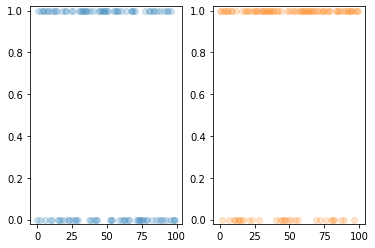

In [104]:
fig, axes = plt.subplots(ncols=n_models) 

colors = [f'C{i}' for i in range(n_models)]

for i, mt in enumerate(model_types):
    ax = axes[i]
    ax.scatter(range(T), choices[mt], color=colors[i], alpha=0.2)
    ax.set_ylim(-0.02, 1.02)
plt.show()

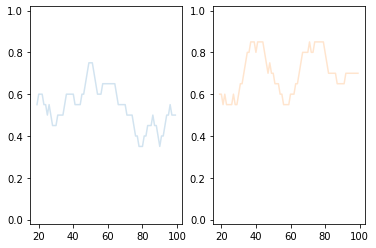

In [105]:
window = 20

fig, axes = plt.subplots(ncols=n_models) 

colors = [f'C{i}' for i in range(n_models)]

for i, mt in enumerate(model_types):
    ax = axes[i]
    ax.plot(pd.Series(choices[mt]).rolling(window).mean(), 
            color=colors[i], alpha=0.2)
    ax.set_ylim(-0.02, 1.02)
plt.show()

In [106]:
import statsmodels.stats.proportion 
import scipy.stats
for i, mt in enumerate(model_types):
    obs = choices[mt]
    k, n = np.sum(obs), len(obs)
    print(statsmodels.stats.proportion.proportion_confint(count=k, nobs=n))
    freq_yes = k/n
    freq_no = 1- freq_yes
    chi2, p = scipy.stats.chisquare((k, n-k))
    print(chi2, p)

(0.432178356575096, 0.6278216434249041)
0.36 0.5485062355001471
(0.6210642720173202, 0.7989357279826798)
17.64 2.6691498031812692e-05


In [ ]:
class Optimizer:
    
    def __init__(self, objective, task_parameters, 
                 history,
                 model, bounds):
        
        self.task_parameters = task_parameters
        self.objective = objective
        self.history = history
        self.model = model
        self.bounds = bounds
    
    def _func(self, param):
        
        return self.objective(self.model, param, self.history, 
                              **self.task_parameters)
        
    def run(self):

        res = scipy.optimize.differential_evolution(
            func=self._func,
            bounds=self.bounds)
        best_param = res.x
        best_value = res.fun
        
        return best_param, best_value


Determine le (log) likelihood of your model

\begin{equation}
\log p(D \mid M, \theta) = \sum_{d \in D} \log p(d \mid M, \theta)
\end{equation}


In [ ]:
def bandit_objective(model,
              param,
            history,
                     n_option):
    
    n_iteration = len(history)
    agent = model(n_option=n_option, *param)

    log_likelihood = np.zeros(n_iteration)

   # Simulate the task
    for t in range(n_iteration):
        
        choice, success = history[t]
        
        ps = agent.decision_rule()
        p = ps[choice]
        
        log_likelihood[t] = np.log(p + EPS)
        
        # Make agent learn
        agent.learn(i=choice, success=s)

    return np.sum(log_likelihood)

\begin{equation}
\text{BIC} = - 2 \log p(D\mid {\widehat {\theta }},M) + k \log(T)
\end{equation}

In [ ]:
def bic(ll, k, n_iteration):
    return -2 *ll + k * np.log(n_iteration)
